In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

#### Part1. 数据预处理，切分训练集和测试集

In [3]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [5]:
unique_list = list()
for x in df.columns:
    if len(df[x].unique()) == 1:
        unique_list.append(x)
print('unique_list: ', unique_list)

unique_list:  []


In [6]:
df = df.fillna(0)

In [7]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [8]:
one_hot_list = list()
for i in range(len(df.columns)):
    if df.dtypes[i] == 'object':
        one_hot_list.append(df.columns[i])

In [9]:
X = df.drop('SalePrice', axis=1, inplace=False)
y = df['SalePrice']

In [10]:
X_encoded = pd.get_dummies(X, columns=one_hot_list)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=123412, train_size=0.75, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1095, 305) (365, 305) (1095,) (365,)


#### Part2. Xgboost测试

In [12]:
reg_xgb = xgb.XGBRegressor(
    objective='reg:linear',   #损失函数
    eval_metric='rmse',       #模型评判指标
    tree_method='approx',     #近似贪婪
    missing=np.nan, 
    n_estimators = 100,      #停止条件
    seed=112,
    learning_rate=0.1,        #学习率（需要优化）
    gamma=10,                 #剪枝参数（需要优化）
    subsample=0.8,            #子样本（需要优化）
    colsample_bytree=0.5,     #每棵子树的变量选取比例（需要优化）
    reg_lambda=1,             #正则化参数（需要优化）
    max_depth=4,              #树最大深度（需要优化）
    )
result = reg_xgb.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
print('-----> The best metric: ', result.evals_result_['validation_0']['rmse'][-1])

[11:01:43] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
-----> The best metric:  32203.537109


##### 拟合效果

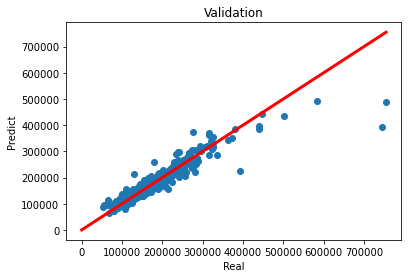

In [13]:
y_test_pred = reg_xgb.predict(X_test)
plt.title('Validation')
plt.xlabel('Real')
plt.ylabel('Predict')
plt.scatter(y_test, y_test_pred)
plt.plot([0, max(y_test)], [0, max(y_test)], c='r', linewidth=3)
plt.show()

##### XGBoost参数调优

In [14]:
reg_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',   #损失函数
    tree_method='approx',     #近似贪婪
    missing=np.nan, 
    n_estimators = 100,      #停止条件
    seed=112,
    )
grid_param = {
    'learning_rate': np.linspace(0.05, 1, 20),
    'gamma': np.linspace(0, 10, 10),
    'subsample': np.linspace(0.55, 1, 10),
    'colsample_bytree': np.linspace(0.5, 1, 11),
    'reg_lambda': np.linspace(0, 10, 10),
    'max_depth': [3, 4, 5, 6, 7]
    }
rand_sear = RandomizedSearchCV(reg_xgb, grid_param, n_iter=10, scoring='neg_root_mean_squared_error', cv=4)
rand_sear.fit(X_encoded, y)

RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                        'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [15]:
print(rand_sear.best_score_)
print(rand_sear.best_params_)
print(rand_sear.best_estimator_)

-28008.850259041214
{'subsample': 1.0, 'reg_lambda': 7.777777777777779, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 10.0, 'colsample_bytree': 0.8}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=10.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=112,
             reg_alpha=0, reg_lambda=7.777777777777779, scale_pos_weight=1,
             seed=112, subsample=1.0, tree_method='approx',
             validate_parameters=1, verbosity=None)


-----> The best metric:  32658.675781


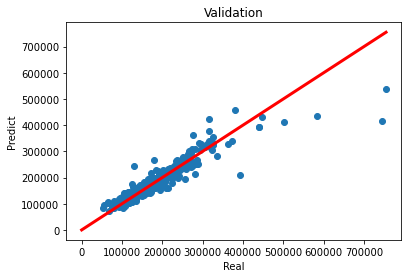

In [16]:
reg_xgb = rand_sear.best_estimator_
result = reg_xgb.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
print('-----> The best metric: ', result.evals_result_['validation_0']['rmse'][-1])
y_test_pred = reg_xgb.predict(X_test)
plt.title('Validation')
plt.xlabel('Real')
plt.ylabel('Predict')
plt.scatter(y_test, y_test_pred)
plt.plot([0, max(y_test)], [0, max(y_test)], c='r', linewidth=3)
plt.show()

#### Part3. Lightgbm测试

LightGBM训练10000棵决策树，用时2.5秒。

In [18]:
reg_lgb = lgb.LGBMRegressor(
    objective='rmse', 
    metric='rmse',
    boosting_type='gbdt',
    n_estimators=10000,  
    random_state=112, 
    learning_rate=0.1,
    min_split_gain=20, 
    subsample=0.85, 
    colsample_bytree=0.5, 
    reg_lambda=1, 
    max_depth=4,
)
result = reg_lgb.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
print('-----> The best metric: ', result.evals_result_['valid_0']['rmse'][-1])


d:\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


-----> The best metric:  30083.283334563173


##### Lightgbm与Xgboost的效率对比

用Xgboost_approx训练10000棵决策树，用时27.6s，Lightgbm的效率是Xgboost_approx(采用近似贪心算法)的的11倍。

In [19]:
reg_xgb = xgb.XGBRegressor(
    objective='reg:linear', 
    eval_metric='rmse', 
    tree_method='approx', 
    missing=np.nan, 
    n_estimators = 10000, 
    seed=112,
    learning_rate=0.1, 
    gamma=10, 
    subsample=0.8, 
    colsample_bytree=0.5, 
    reg_lambda=1, 
    max_depth=4, 
    )
result = reg_xgb.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
print('-----> The best metric: ', result.evals_result_['validation_0']['rmse'][-1])

[11:02:03] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
-----> The best metric:  31040.769531


用Xgboost_hist训练10000棵决策树，用时18.7s，Lightgbm的效率是Xgboost_hist(采用了lightgbm的直方图算法)的7倍。

In [20]:
reg_xgb = xgb.XGBRegressor(
    objective='reg:linear', 
    eval_metric='rmse', 
    tree_method='hist', 
    missing=np.nan, 
    n_estimators = 10000, 
    seed=112,
    learning_rate=0.1, 
    gamma=10, 
    subsample=0.8, 
    colsample_bytree=0.5, 
    reg_lambda=1, 
    max_depth=4, 
    )
result = reg_xgb.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
print('-----> The best metric: ', result.evals_result_['validation_0']['rmse'][-1])

[11:02:31] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
-----> The best metric:  29296.482422


##### LightGBM参数调优

In [21]:
reg_lgb = lgb.LGBMRegressor(
    objective='rmse', 
    boosting_type='gbdt',
    n_estimators=100,  
    random_state=112, 
    )
grid_param = {
    'learning_rate': np.linspace(0.05, 1, 20),
    'min_split_gain': np.linspace(0, 10, 50),
    'subsample': np.linspace(0.55, 1, 10),
    'colsample_bytree': np.linspace(0.5, 1, 11),
    'reg_lambda': np.linspace(0, 10, 10),
    'max_depth': [3, 4, 5, 6, 7]
    }
rand_sear = RandomizedSearchCV(reg_lgb, grid_param, n_iter=100, scoring='neg_root_mean_squared_error', cv=4)
rand_sear.fit(X_encoded, y)

RandomizedSearchCV(cv=4,
                   estimator=LGBMRegressor(objective='rmse', random_state=112),
                   n_iter=100,
                   param_distributions={'colsample_bytree': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_split_gain': arra...
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ]),
                                        'reg_lambda': array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.8888888

In [22]:
print(rand_sear.best_score_)
print(rand_sear.best_params_)
print(rand_sear.best_estimator_)

-26866.368536205147
{'subsample': 0.8, 'reg_lambda': 4.444444444444445, 'min_split_gain': 1.6326530612244898, 'max_depth': 4, 'learning_rate': 0.15, 'colsample_bytree': 0.8}
LGBMRegressor(colsample_bytree=0.8, learning_rate=0.15, max_depth=4,
              min_split_gain=1.6326530612244898, objective='rmse',
              random_state=112, reg_lambda=4.444444444444445, subsample=0.8)


-----> The best metric:  31037.51982075876


d:\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


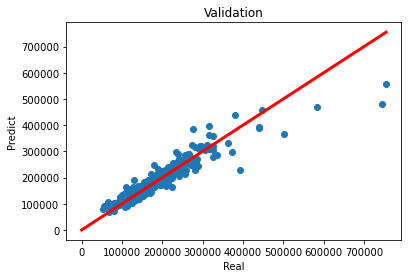

In [23]:
reg_lgb = rand_sear.best_estimator_
result = reg_lgb.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
print('-----> The best metric: ', result.evals_result_['valid_0']['rmse'][-1])
y_test_pred = reg_xgb.predict(X_test)
plt.title('Validation')
plt.xlabel('Real')
plt.ylabel('Predict')
plt.scatter(y_test, y_test_pred)
plt.plot([0, max(y_test)], [0, max(y_test)], c='r', linewidth=3)
plt.show()

#### Part4.Random Forest测试

In [38]:
reg_rf = RandomForestRegressor(
    n_estimators=100,
    criterion= "mse",
    max_features='sqrt', 
    bootstrap=True, 
    oob_score=True,
    random_state=112,
    )
result = reg_rf.fit(X_train, y_train)

##### 拟合效果

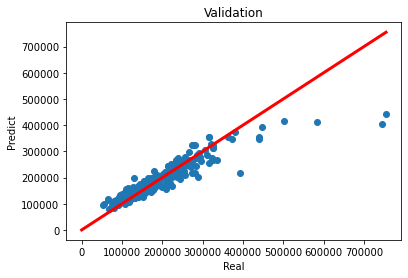

In [41]:
y_test_pred = result.predict(X_test)
plt.title('Validation')
plt.xlabel('Real')
plt.ylabel('Predict')
plt.scatter(y_test, y_test_pred)
plt.plot([0, max(y_test)], [0, max(y_test)], c='r', linewidth=3)
plt.show()

##### 特征重要性

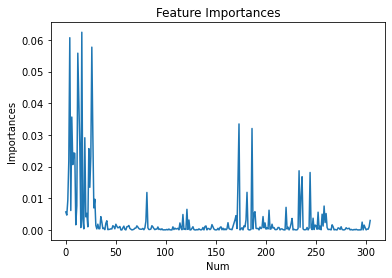

In [57]:
plt.plot(result.feature_importances_)
plt.title('Feature Importances')
plt.xlabel('Num')
plt.ylabel('Importances')
plt.show()